In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit_aer import Aer
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.circuit.library import QFT
from fractions import Fraction
import numpy as np
from math import gcd

# Q.1

### a) Swap states of two qubits:

In [2]:
qc = QuantumCircuit(2)
qc.ry(np.random.rand()*2*np.pi,0);
qc.rx(np.random.rand()*2*np.pi,0);

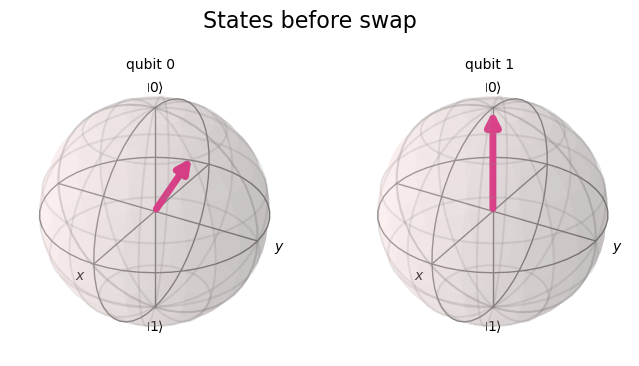

In [3]:
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state, title="States before swap",figsize=(4,4))

In [4]:
qc.cx(0,1)
qc.cx(1,0)
qc.cx(0,1)

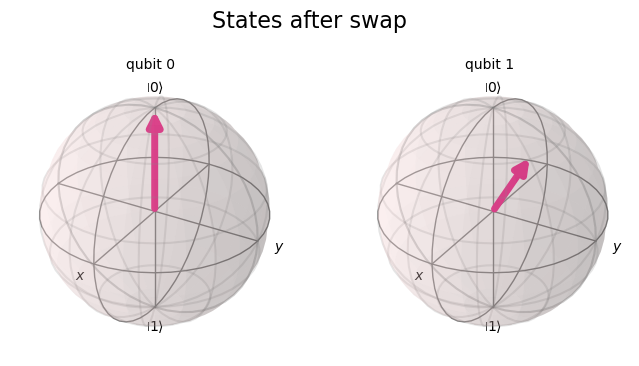

In [5]:
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state, title="States after swap",figsize=(4,4))

### b) Increment a 3-bit binary number by 1(mod8)

In [31]:
def print_state(qc,qr,cr):
    qc.measure(qr[0],cr[0])
    qc.measure(qr[1],cr[1])
    qc.measure(qr[2],cr[2])
    # Transpile the circuit for the simulator
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc, simulator)

    # Execute the transpiled circuit on the simulator
    result = simulator.run(compiled_circuit, shots=1).result()

    # Get the measurement result
    counts = result.get_counts(compiled_circuit)
    state = list(counts.keys())[0]  # Get the measured state (0 or 1)
    print(state)

In [32]:
def create_state(qc,qr):
    a=np.random.randint(0,2);
    if a==0:
        qc.x(qr[0]);
    a=np.random.randint(0,2);
    if a==0:
        qc.x(qr[1]);
    a=np.random.randint(0,2);
    if a==0:
        qc.x(qr[2]);

In [33]:
qr=QuantumRegister(3)
cr=ClassicalRegister(3)

qc=QuantumCircuit(qr,cr);
create_state(qc,qr)
print_state(qc,qr,cr)

001


In [34]:
qc.ccx(0,1,2)
qc.cx(0,1)
qc.x(0)

In [35]:
print_state(qc,qr,cr)

010


### c) Adding two 3-bit binary numbers

In [41]:
a=QuantumRegister(3,'a')
b=QuantumRegister(3,'b')
an=QuantumRegister(1,'ancilla')
cr=ClassicalRegister(3)
qc=QuantumCircuit(a,b,an,cr)
create_state(qc,a)
create_state(qc,b)
qc.barrier()
print('a:')
print_state(qc,a,cr)
print('b:')
print_state(qc,b,cr)

a:
111
b:
101


a+b(mod8):
100


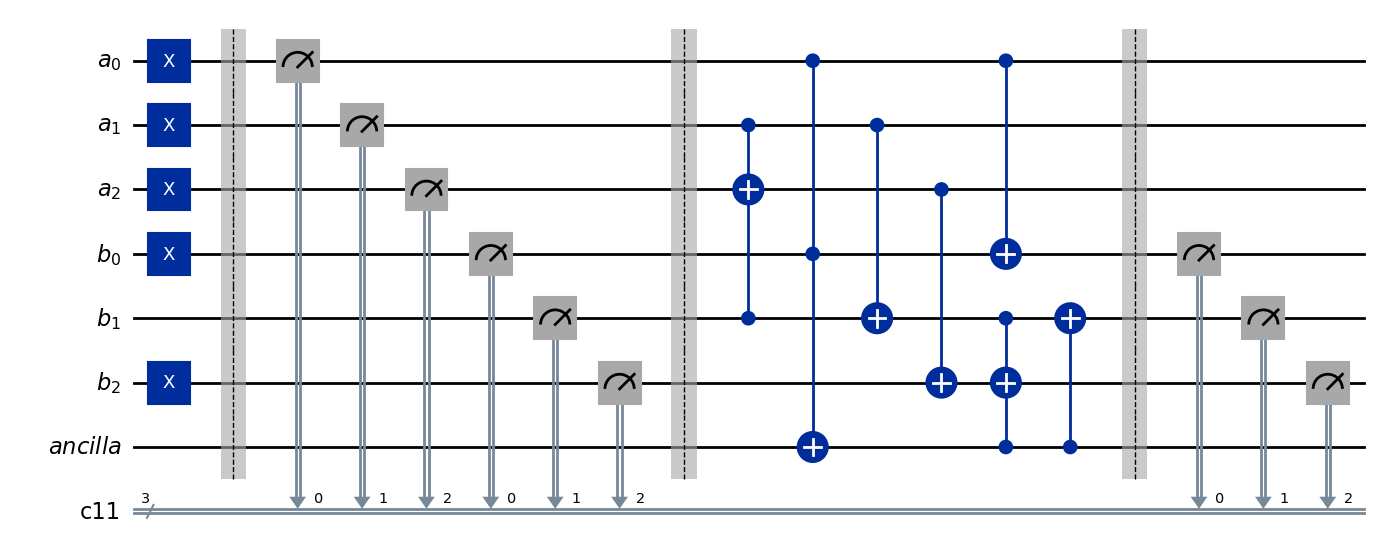

In [42]:
qc.barrier()
qc.ccx(a[1],b[1],a[2])
qc.cx(a[1],b[1])
qc.cx(a[2],b[2])
qc.ccx(a[0],b[0],an[0])
qc.ccx(an[0],b[1],b[2])
qc.cx(an[0],b[1])
qc.cx(a[0],b[0])
qc.barrier()
print('a+b(mod8):')
print_state(qc,b,cr)
qc.draw('mpl')

### d) Calculating Hamming weight (w(x)) of a n-bit number x

In [13]:
def create_nbit(qc,reg,n):
    for i in range(n):
        p=np.random.randint(0,2)
        if p==0:
            qc.x(reg[i])
def add_one(qc,reg):
    qc.ccx(reg[0],reg[1],reg[2])
    qc.cx(reg[0],reg[1])
    qc.x(reg[0])
def print_state(qc,qr,cr,n):
    for i in range(n):
        qc.measure(qr[i],cr[i])
    # Transpile the circuit for the simulator
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc, simulator)

    # Execute the transpiled circuit on the simulator
    result = simulator.run(compiled_circuit, shots=1).result()

    # Get the measurement result
    counts = result.get_counts(compiled_circuit)
    state = list(counts.keys())[0]  # Get the measured state (0 or 1)
    return state

In [14]:
n=5
q=QuantumRegister(n,'q')
w=QuantumRegister(int(np.ceil(np.log2(n))),'w')
cq=ClassicalRegister(n)
cw=ClassicalRegister(int(np.ceil(np.log2(n))))
qc=QuantumCircuit(q,w,cw,cq)
create_nbit(qc,q,n)
qc.barrier()
state=print_state(qc,q,cq,n)
print("x:    w:")
print(state)

x:    w:
10101 000


In [15]:
for i in range(n):
    if state[i]=='1':
        add_one(qc,w)

In [16]:
state=print_state(qc,w,cw,int(np.ceil(np.log2(n))))
print("x:    w:")
print(state)

x:    w:
10101 011


# Q.2

## a) Implementing Deutsch-Josza Algorithm

In [17]:
#creating a balanced oracle
def balanced_oracle(circuit, n):
    for i in range(n):
        circuit.cx(i, n)
#creating an unbalanced oracle
def constant_oracle(circuit, n):
    p=np.random.randint(0,2)
    if p==0:
        pass
    else:
        circuit.x(n)

def create_x(circuit,n):
    for i in range(n):
        a=np.random.randint(0,2)
        if a==0:
            circuit.x(i)

0
Measurement results: {'11111111': 1024}
The function is balanced.


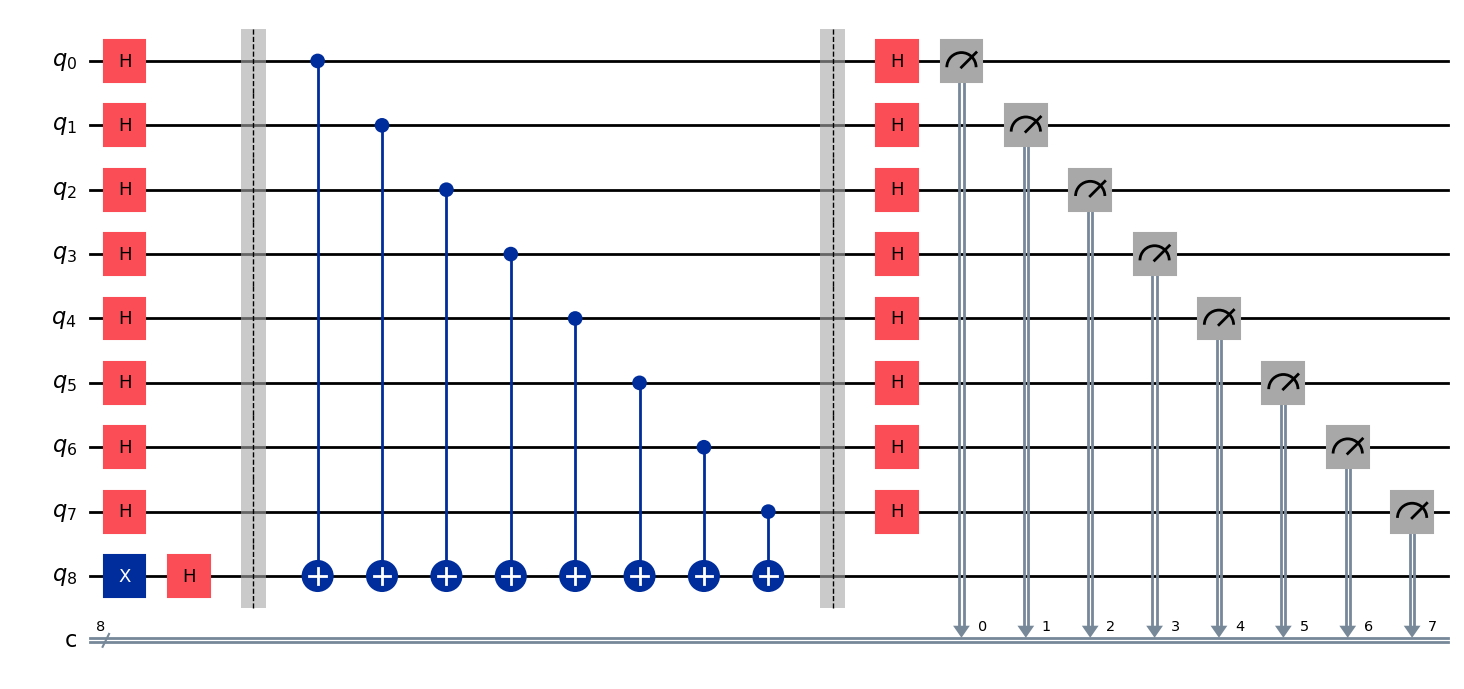

In [50]:
n=8
djc = QuantumCircuit(n + 1, n)
djc.x(n)
djc.h(range(n + 1))
djc.barrier()
q=np.random.randint(0,2)
if q==0:
    balanced_oracle(djc,n)
if q==1:
    constant_oracle(djc,n)
    
djc.barrier()
djc.h(range(n))
djc.measure(range(n), range(n))
print(q)

simulator = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(djc, simulator)

# Simulate the transpiled circuit
result = simulator.run(transpiled_circuit).result()

# Print the measurement results
print("Measurement results:", result.get_counts())

# Determine if the function is constant or balanced
if all(count == '0' * n for count in result.get_counts()):
    print("The function is constant.")
else:
    print("The function is balanced.")
    
djc.draw('mpl')

## b) Implementing Bernstein-Vazirani Algorithm

Secret string: {'1011010': 1024}


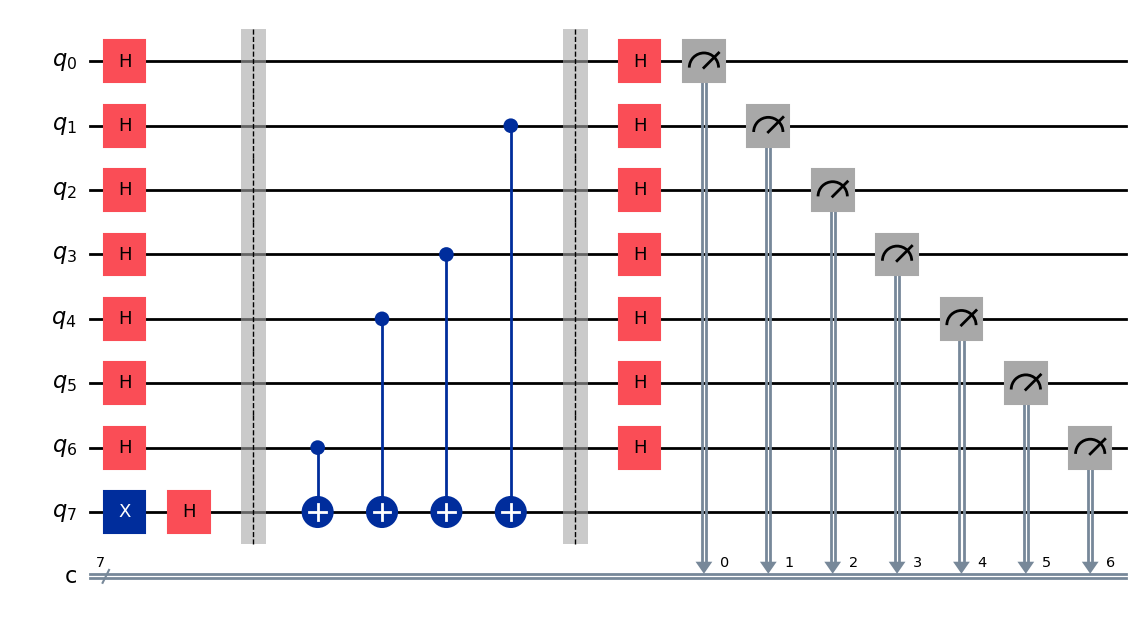

In [54]:
n = 7

#Create the quantum circuit and initialize states
bvc = QuantumCircuit(n + 1, n)
bvc.x(n)
bvc.h(range(n+1))
bvc.barrier()
# Apply the quantum oracle based on the secret string
secret_string = '1011010'
for i, bit in enumerate(secret_string):
    if bit == '1':
        bvc.cx(n-1-i, n)
bvc.barrier()
# Apply Hadamard gates again
bvc.h(range(n))

# Measure the input qubits
bvc.measure(range(n), range(n))

simulator = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(bvc, simulator)

# Simulate the transpiled circuit
result = simulator.run(transpiled_circuit).result()

# Print the measurement results
print("Secret string:", result.get_counts())
bvc.draw('mpl')

# Q.3

## GHZ Game (Quantum Pseudo-Telepathy)

They win only when $a\bigoplus b\bigoplus c=r\vee s\vee t$. If r,s,t are all 0's, then a,b,c must be either 2 1's or all 0's (even sum). If otherwise, then a,b,c must be either all 1's or 2 0's (odd sum). 

### Classical Case:
Classically, Alice, Bob, and Charlie can employ a deterministic strategy that always end up with odd sum (e.g. Alice always output 1. Bob and Charlie always output 0). The players win 75% of the time and only lose if the questions are (0,0,0). We can show that's the best strategy classically. They can atmost win 3/4 times. Let $a_0, a_1$ be Alice's response to question 0 and 1 respectively, $b_0, b_1$ be Bob's response to question 0, 1, and $c_0, c_1$ be Charlie's response to question 0, 1. Then we have,
$a_0+b_0+c_0=0$ mod 2
<br>
$a_1+b_1+c_0=1$ mod 2
<br>
$a_1+b_0+c_1=1$ mod 2
<br>
$a_0+b_1+c_1=1$ mod 2
<br>
Let's assume that by some classical strategy all these conditions are satisfied and the players win with probability 1. Adding all these four equations, we get, the left side sum = 0 mod 2 and the right side sum = 1 mod 2. So that's a contradiction. Hence proved.

### Quantum Case:
The quantum strategy is as follows:
<br>
The three of them are made to share the GHZ state ($|\psi\rangle=\frac{|000\rangle+|111\rangle}{\sqrt{2}}$). Now the following algorithm is performed:
<br>
i) If question 0 is received, the player makes a measurement in the X basis, {$|+\rangle_x,\;|-\rangle_x$}.<br>
ii) If question 1 is received, the player makes a measurement in the Y basis, {$|+\rangle_y,\;|-\rangle_y$}.<br>
iii) In both cases, the players give answer 0 if the result of the measurement is the first state of the pair, and answer 1 if the result is the second state of the pair.<br>
<br>
If they receive 000 ($r\vee s\vee t=0$) from the referee, they would all make X measurements. So it will of an XXX type measurement. Now the GHZ state written in XXX basis (writing each qubit state in x basis and taking the outer product) is: $|\psi\rangle=\frac{1}{2}(|000\rangle+|011\rangle+|101\rangle+|110\rangle)$, where $|0\rangle$ and $|1\rangle$ are the X-basis. Making an XXX measurement will therefore collapse the GHZ into one of these states. As can be noted easily, here, $a\bigoplus b\bigoplus c=0$, therefore the players win.
<br><br>
On the other hand, if the players get 011, 101, 110 ($r\vee s\vee t=1$) then they would make an XYY, YXY or YYX type measurement. Now the GHZ state in XYY, YXY or YYX basis (writing one of the qubit state in x basis and the other two in y basis and taking the outer product) is: $|\psi\rangle=\frac{1}{2}(|001\rangle+|010\rangle+|100\rangle+|111\rangle)$. Now, here, $a\bigoplus b\bigoplus c=1$, therefore the players win again.
<br>
Therefore their winning probability becomes 1.

# Q.4

## a) Implementing Quantum Fourier Transform

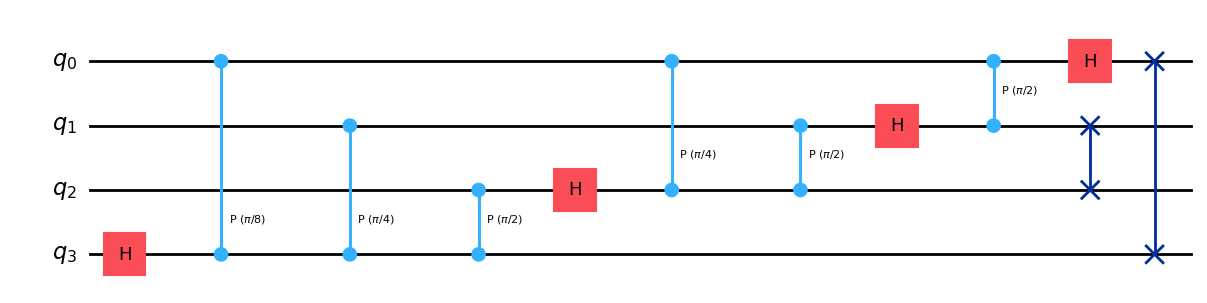

In [20]:
n=4
qft=QuantumCircuit(n)
for j in range(n):
    qubit=n-1-j
    qft.h(qubit)
    for i in range(qubit):
        theta=np.pi/2**(qubit-i)
        qft.cp(theta,i,qubit)
for qubit in range(n//2):
    qft.swap(qubit,n-1-qubit)
qft.draw('mpl')

## b) Implementing Quantum Phase Estimation

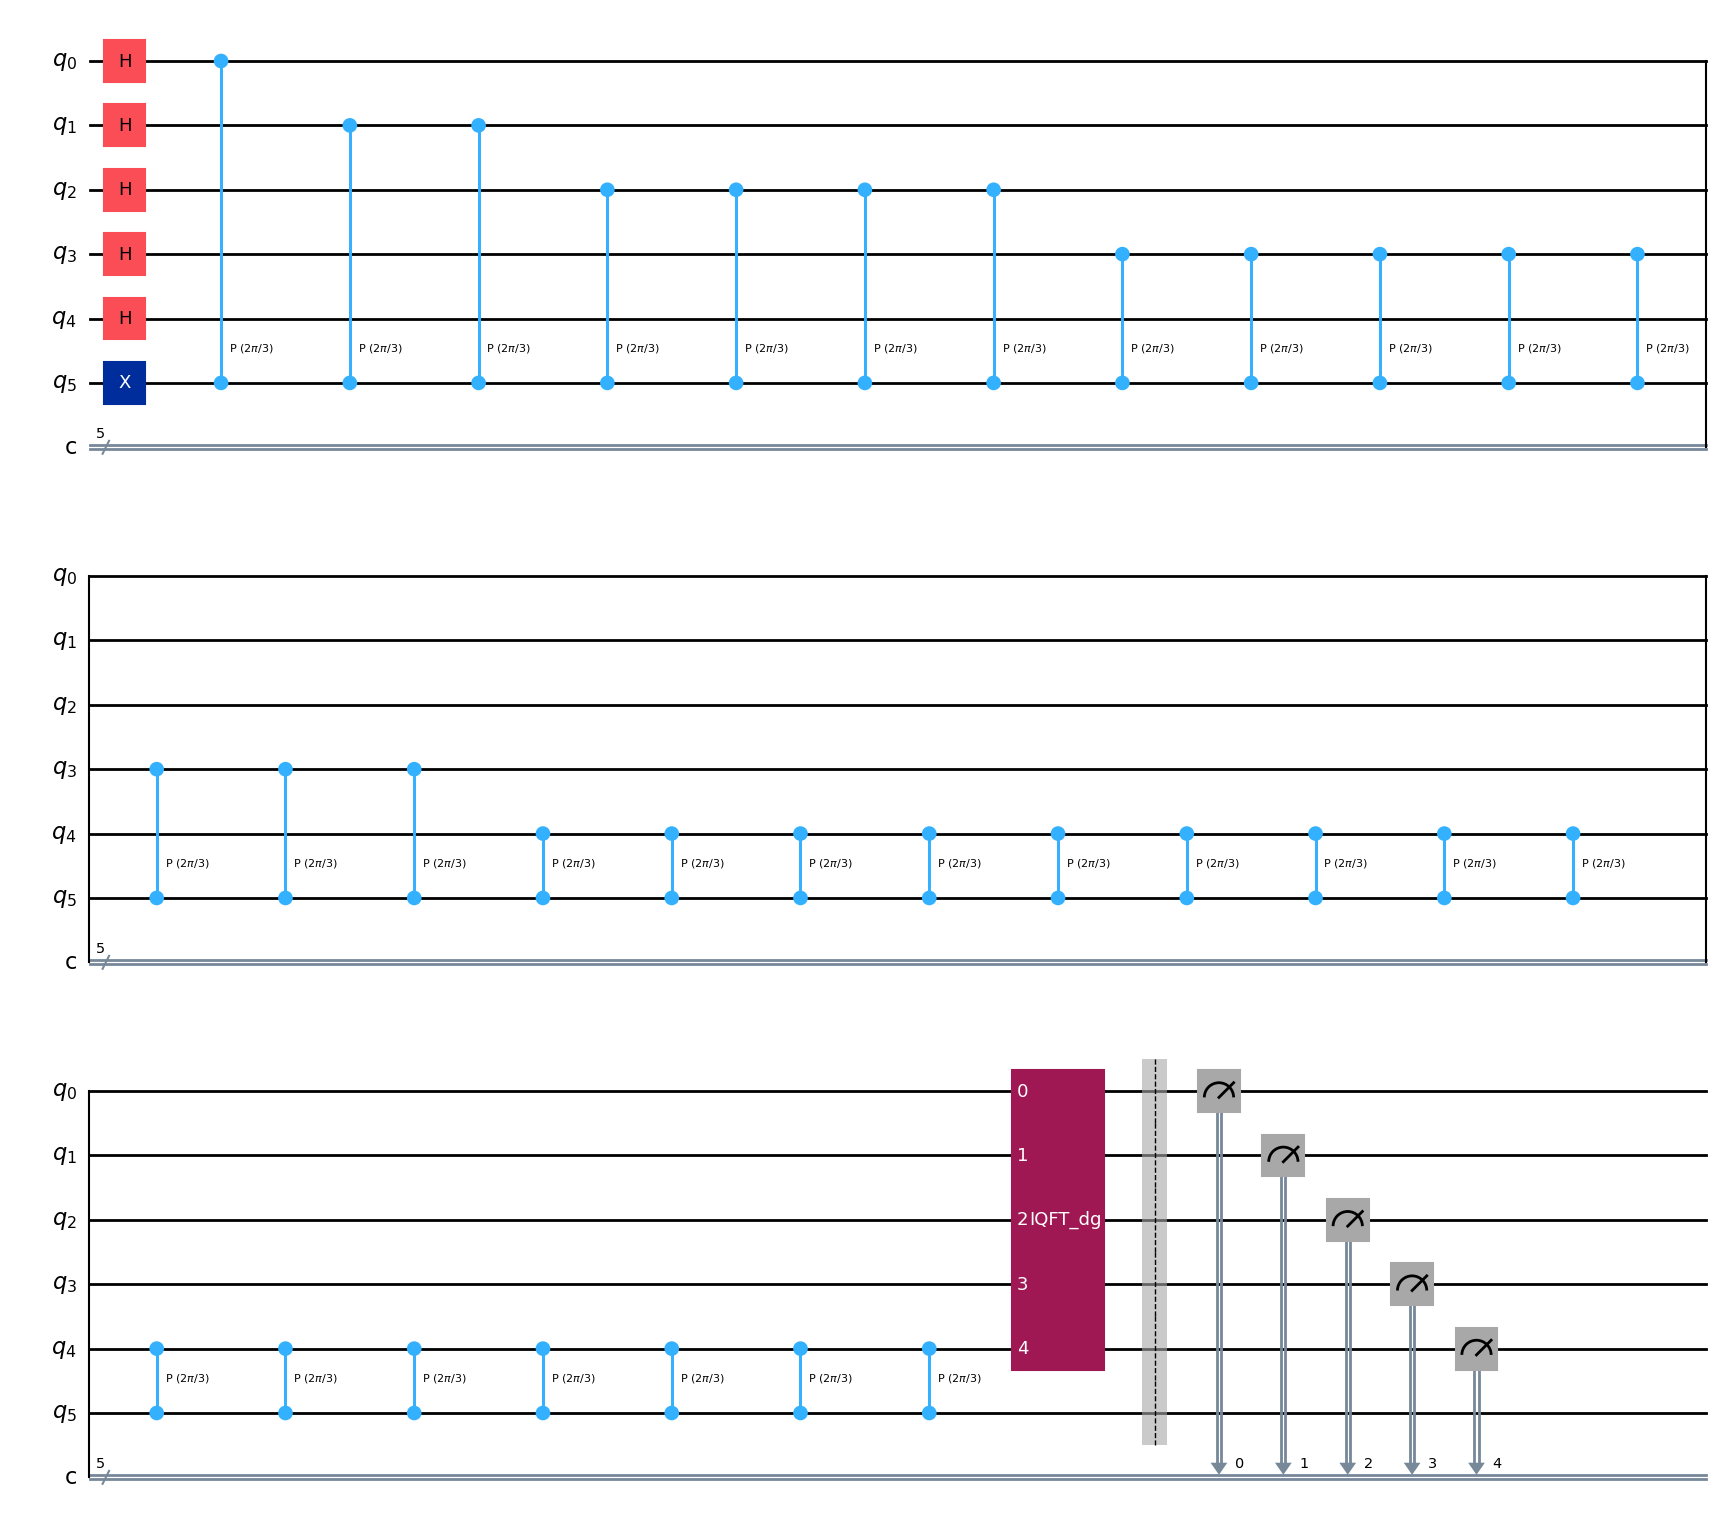

In [56]:
n = 5

# Create a quantum circuit
qpe = QuantumCircuit(n + 1,n)

# Apply Hadamard gates to counting qubits
for qubit in range(n):
    qpe.h(qubit)
qpe.x(n)
angle = 2*np.pi/3 #2pi * theta. we will find theta through this algorithm.
r=1
for qubit in range(n):
    for i in range(r):
        qpe.cp(angle,qubit,n)
    r*=2
qpe=qpe.compose(QFT(n, inverse=True), range(n))
qpe.barrier()
for i in range(n):
    qpe.measure(i,i)
qpe.draw('mpl')

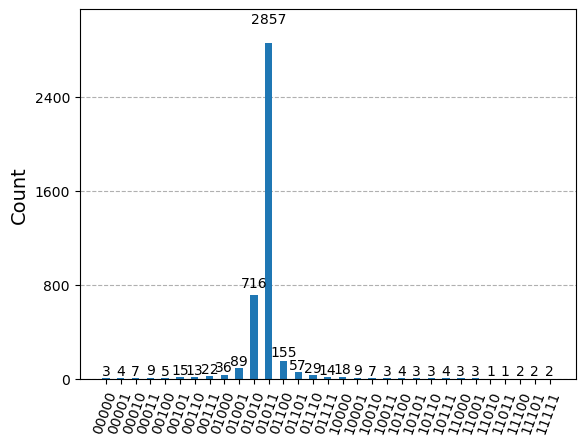

In [22]:
simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(qpe, simulator)

result = simulator.run(transpiled_circuit,shots=4096).result()
counts=result.get_counts()
plot_histogram(counts)

The two most likely measurements 01011 and 01010 in decimal are 11 and 10.
<br>
$\theta=\frac{11}{2^5}=0.344$ or $\theta=\frac{10}{2^5}=0.313$. They are almost equal to $\frac{1}{3}$ which is our required result.

## c) Implementing Shor's Algorithm

In [23]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [60]:
N_COUNT = 8  # number of counting qubits
a = 7

# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc=qc.compose(QFT(N_COUNT, inverse=True), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw('mpl')
aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
readings = job.result().get_memory()
print("Register Reading: " + readings[0])
phase = int(readings[0],2)/(2**N_COUNT)
print(f"Corresponding Phase: {phase}")
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)
guesses = [gcd(a**(r//2)-1, 15), gcd(a**(r//2)+1, 15)]
print('Prime factors of 15 :', guesses)

Register Reading: 01000000
Corresponding Phase: 0.25
4
Prime factors of 15 : [3, 5]


## d) Implementing Grover's Algorithm

For winning state: 111
<br>
The optimal number of iterations required: $\left\lfloor{\frac{\pi}{4}\sqrt{\frac{N}{m}}}\right \rfloor$. Here N=8 and m=1. So, it's 2. 

In [25]:
def oracle_ga3(qc):
    qc.ccz(0,1,2)
def diffuser_ga3(qc):
    qc.h(range(3))
    qc.x(range(3))
    qc.ccz(0,1,2)
    qc.x(range(3))
    qc.h(range(3))

In [26]:
#iterated once
qr=QuantumRegister(3,'q')
cr=ClassicalRegister(3)
gac=QuantumCircuit(qr,cr)
gac.h(range(3))
oracle_ga3(gac)
diffuser_ga3(gac)

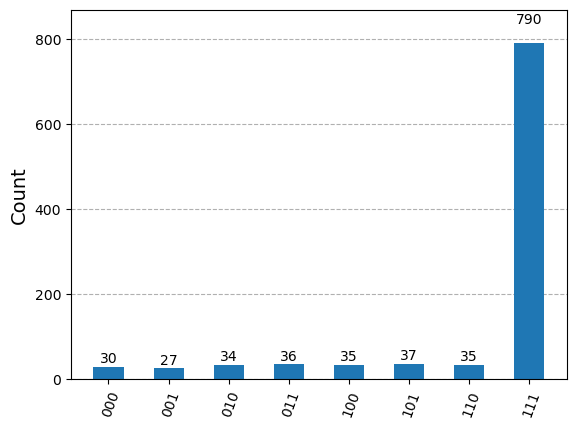

In [27]:
gac.measure(qr,cr)

simulator = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(gac, simulator)

result = simulator.run(transpiled_circuit).result()
counts=result.get_counts()
plot_histogram(counts)

In [61]:
#iterated twice
qr=QuantumRegister(3,'q')
cr=ClassicalRegister(3)
gac=QuantumCircuit(qr,cr)
gac.h(range(3))
oracle_ga3(gac)
diffuser_ga3(gac)
oracle_ga3(gac)
diffuser_ga3(gac)

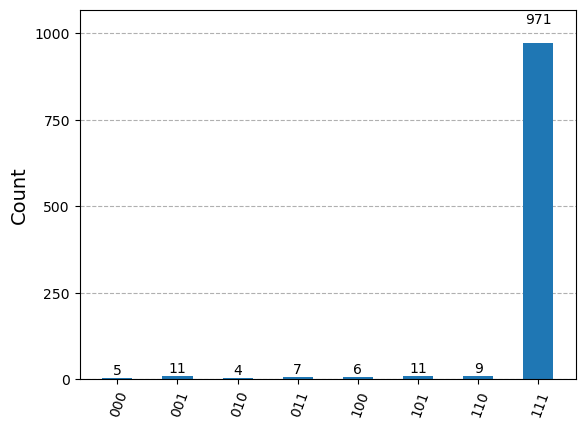

In [62]:
gac.measure(qr,cr)

simulator = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(gac, simulator)

result = simulator.run(transpiled_circuit).result()
counts=result.get_counts()
plot_histogram(counts)